In [11]:
import numpy as np
import pandas as pd
import duckdb

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import FeatureImportances

from sklearn.impute import KNNImputer

In [2]:
con = duckdb.connect(database="./genie.duckdb", read_only=True)

In [3]:
df = pd.read_csv('genie-cohorts.csv')
df['cht'] = df['cht'].replace({
    0: 'Asian Female', 
    1: 'Asian Male', 
    2: 'Black Female', 
    3: 'Black Male', 
    4: 'White Female', 
    5: 'White Male'
})
df.tail()

,tissuename,ABI1,ABL1,ABL2,ACKR3,ACSL6,ACVR1,ACVR2A,AFDN,AFF1,...,ZBTB16,ZFHX3,ZMYM2,ZMYM3,ZNF331,ZNF384,ZNF521,ZNRF3,ZRSR2,cht
13480,GENIE-UHN-835738-ARC1,0,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,White Male
13481,GENIE-UHN-873889-ARC1,0,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,White Male
13482,GENIE-UHN-904697-ARC1,0,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,White Male
13483,GENIE-UHN-926151-ARC1,0,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,White Male
13484,GENIE-UHN-993750-ARC1,0,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,White Male


In [4]:
y = df['cht']
X = df.drop(columns=['tissuename', 'cht']) # drop the target column

In [5]:
# find features with same value for all samples and drop them
nunique = X.nunique()
cols_to_drop = nunique[nunique <= 1].index # 0 if all are missing, 1 if ther is only one catgeory/value
X_train = X.drop(cols_to_drop, axis='columns').reset_index(drop=True)

In [12]:
imputer = KNNImputer(missing_values=0, n_neighbors=1, weights="distance") 
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

In [13]:
X_train.tail(5)

,ABL1,ABL2,ACVR1,ACVR2A,AFDN,AFF1,AFF3,AKAP9,AKT1,AKT2,...,YWHAE,ZBTB16,ZFHX3,ZMYM2,ZMYM3,ZNF331,ZNF384,ZNF521,ZNRF3,ZRSR2
13480,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
13481,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
13482,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
13483,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
13484,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


<Axes: xlabel='FGFR4', ylabel='Percent'>

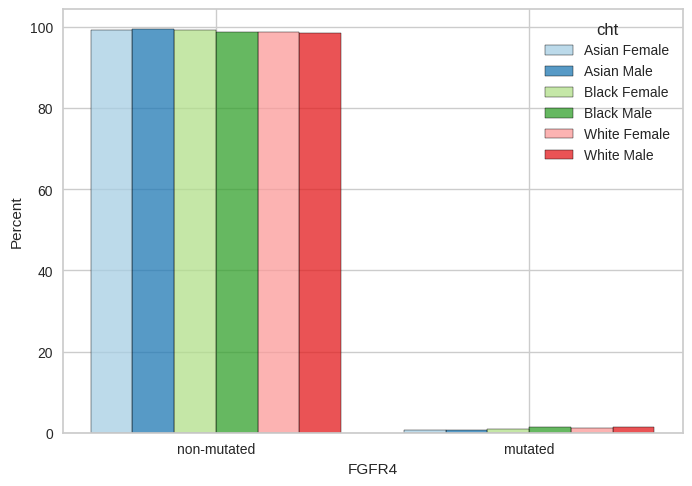

In [14]:
df_prepared = pd.concat([y, X_train], axis=1)
df_prepared['FGFR4'] = df_prepared['FGFR4'].replace({-1: 'non-mutated', 0: 'unknown', 1: 'mutated'})
sns.histplot(x=df_prepared["FGFR4"], hue=df_prepared["cht"], multiple="dodge", shrink=0.8,
                  stat = 'percent', common_norm=False, palette="Paired")

In [15]:
params = {
    "bootstrap": True, # necessary for oob_score --> default: True for Random Forest, False for Extremely Random Forest
    "class_weight": 'balanced',
    "n_estimators": 500,
    "n_jobs": -1,
    "max_depth": 100,
    "max_features": 0.8,
    "min_samples_leaf": 1,
    "oob_score": True,
    "random_state":  42,
  }

In [16]:
forest = RandomForestClassifier(**params)
forest = forest.fit(X_train, y)
forest.score(X_train, y)

0.7138301816833519

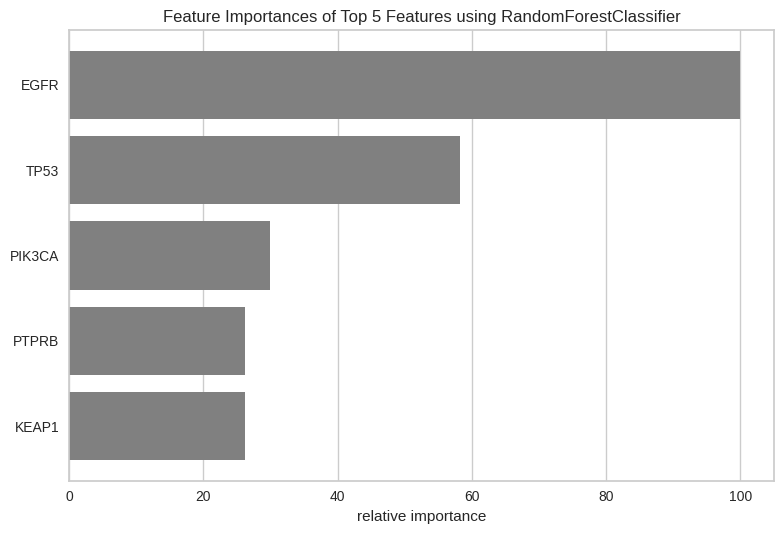

<Axes: title={'center': 'Feature Importances of Top 5 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [17]:
viz = FeatureImportances(forest, topn=5, is_fitted=True, relative=True, colors=["grey"])
viz.fit(X_train, y)
viz.show()